Found 1161 valid input-output pairs.
Inspecting training data samples...
Even input shape: (4, 32, 32, 1)
Odd input shape: (4, 32, 32, 1)
Output shape: (4, 50, 50, 1)


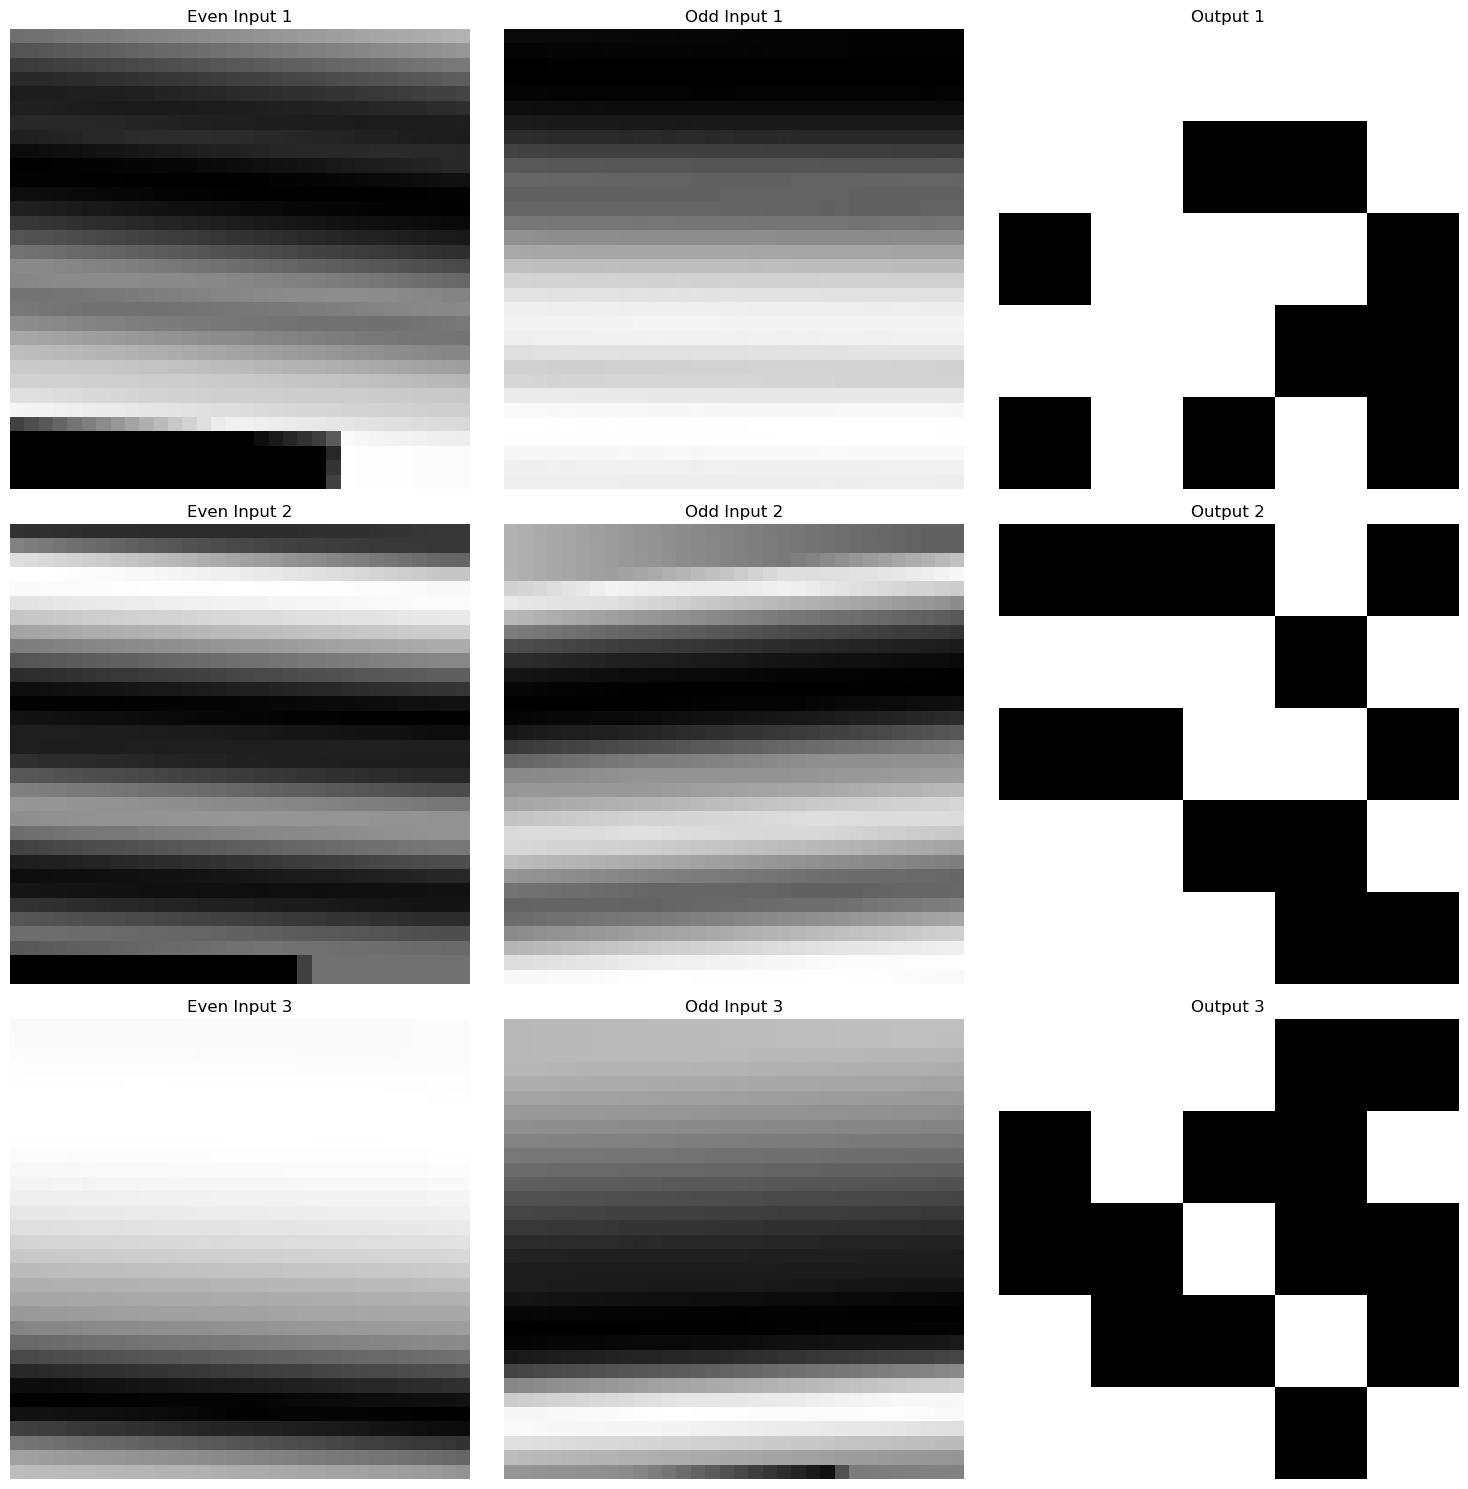

Testing minimal Conv2D model...
Minimal model test passed.
Testing model with dummy data...
Dummy data test passed.
Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5081 - loss: 0.6928 - val_accuracy: 0.5314 - val_loss: 0.6911 - learning_rate: 1.0000e-04
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5197 - loss: 0.6923 - val_accuracy: 0.5409 - val_loss: 0.6896 - learning_rate: 1.0000e-04
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5192 - loss: 0.6921 - val_accuracy: 0.5406 - val_loss: 0.6900 - learning_rate: 1.0000e-04
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5283 - loss: 0.6911 - val_accuracy: 0.5253 - val_loss: 0.6910 - learning_rate: 1.0000e-04
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5259 - loss: 0.6916 - val_accuracy: 0.5421 - val_loss: 0.6884 - learning_rate: 1.0000e-04
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5264 - loss: 0.6908 - val_accura

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force CPU
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)
output_shape = (50, 50, 1)
batch_size = 4
learning_rate = 1e-4
epochs = 50
block_size = 10

# Model
def build_dual_input_model(input_shape, output_shape):
    input_even = layers.Input(shape=input_shape, name="even_input")
    x1 = layers.Conv2D(32, 3, padding="same", activation="relu")(input_even)
    x1 = layers.MaxPooling2D()(x1)  # -> (16, 16, 32)
    x1 = layers.Conv2D(64, 3, padding="same", activation="relu")(x1)  # -> (16, 16, 64)

    input_odd = layers.Input(shape=input_shape, name="odd_input")
    x2 = layers.Conv2D(32, 3, padding="same", activation="relu")(input_odd)
    x2 = layers.MaxPooling2D()(x2)  # -> (16, 16, 32)
    x2 = layers.Conv2D(64, 3, padding="same", activation="relu")(x2)  # -> (16, 16, 64)

    x = layers.Concatenate()([x1, x2])  # -> (16, 16, 128)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)  # Reduce to 64 channels
    x = layers.UpSampling2D()(x)  # -> (32, 32, 64)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)  # -> (32, 32, 32)
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)  # -> (32, 32, 16)
    x = layers.Conv2D(1, 3, padding="same")(x)  # -> (32, 32, 1)
    x = layers.Resizing(output_shape[0], output_shape[1])(x)
    output = layers.Activation("sigmoid")(x)

    return models.Model(inputs=[input_even, input_odd], outputs=output)

# Data Generator
class ImagePairGenerator(Sequence):
    def __init__(self, even_dir, odd_dir, out_dir, batch_size, input_shape, output_shape, pairs, augment=False):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.out_dir = out_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.pairs = pairs
        self.augment = augment
        self.augmentation = KerasImageDataGenerator(
            rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
            zoom_range=0.1, horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        even_batch = np.zeros((len(batch), *self.input_shape))
        odd_batch = np.zeros((len(batch), *self.input_shape))
        out_batch = np.zeros((len(batch), *self.output_shape))

        for i, (e_path, o_path, m_path) in enumerate(batch):
            try:
                even = np.expand_dims(np.array(Image.open(e_path).convert('L').resize(self.input_shape[:2])) / 255.0, -1)
                odd = np.expand_dims(np.array(Image.open(o_path).convert('L').resize(self.input_shape[:2])) / 255.0, -1)
                matrix_img = np.array(Image.open(m_path).convert('L').resize(self.output_shape[:2]))
                matrix_bin = (matrix_img > 128).astype(np.float32)
                matrix_bin = matrix_bin.reshape(5, block_size, 5, block_size).mean(axis=(1, 3))
                matrix_bin = np.repeat(np.repeat((matrix_bin > 0.5).astype(np.float32), block_size, axis=0), block_size, axis=1)
                matrix_bin = np.expand_dims(matrix_bin, -1)

                if self.augment:
                    even = self.augmentation.random_transform(even)
                    odd = self.augmentation.random_transform(odd)

                even_batch[i] = even
                odd_batch[i] = odd
                out_batch[i] = matrix_bin
            except Exception as e:
                print(f"Error processing pair {e_path}, {o_path}, {m_path}: {str(e)}")
                continue

        return (even_batch, odd_batch), out_batch

# Prepare dataset
def get_valid_pairs():
    pairs = []
    missing_ids = []
    for f in os.listdir(output_dir):
        if not f.endswith('.png'):
            continue
        base = f[:-4]
        even_path = os.path.join(input_even_dir, f"{base}_even.png")
        odd_path = os.path.join(input_odd_dir, f"{base}_odd.png")
        out_path = os.path.join(output_dir, f)
        if os.path.exists(even_path) and os.path.exists(odd_path):
            pairs.append((even_path, odd_path, out_path))
        else:
            missing_ids.append(base)
    if missing_ids:
        print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
    return pairs

# Inspect data
def inspect_data(generator, num_samples=3):
    (even_inputs, odd_inputs), outputs = generator[0]
    print("Even input shape:", even_inputs.shape)
    print("Odd input shape:", odd_inputs.shape)
    print("Output shape:", outputs.shape)
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Output {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

pairs = get_valid_pairs()
print(f"Found {len(pairs)} valid input-output pairs.")
np.random.shuffle(pairs)
split = int(0.8 * len(pairs))
train_pairs = pairs[:split]
val_pairs = pairs[split:]

train_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, train_pairs, augment=True)
val_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, val_pairs)

# Inspect data before training
print("Inspecting training data samples...")
inspect_data(train_gen)

# Test minimal model
print("Testing minimal Conv2D model...")
input_test = layers.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_test)
model_test = models.Model(inputs=input_test, outputs=x)
model_test.compile(optimizer='adam', loss='mse')
try:
    model_test.predict(np.zeros((1, 32, 32, 1)), verbose=0)
    print("Minimal model test passed.")
except Exception as e:
    print(f"Minimal model test failed: {str(e)}")

# Test model with dummy data
print("Testing model with dummy data...")
model = build_dual_input_model(input_shape, output_shape)
model.compile(optimizer='adam', loss='binary_crossentropy')
try:
    dummy_even = np.random.rand(4, 32, 32, 1).astype(np.float32)
    dummy_odd = np.random.rand(4, 32, 32, 1).astype(np.float32)
    dummy_out = np.random.randint(0, 2, (4, 50, 50, 1)).astype(np.float32)
    model.train_on_batch([dummy_even, dummy_odd], dummy_out)
    print("Dummy data test passed.")
except Exception as e:
    print(f"Dummy data test failed: {str(e)}")

model = build_dual_input_model(input_shape, output_shape)
model.compile(optimizer=optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Train using generator directly
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)
model.save("image_translation_model_final.keras")

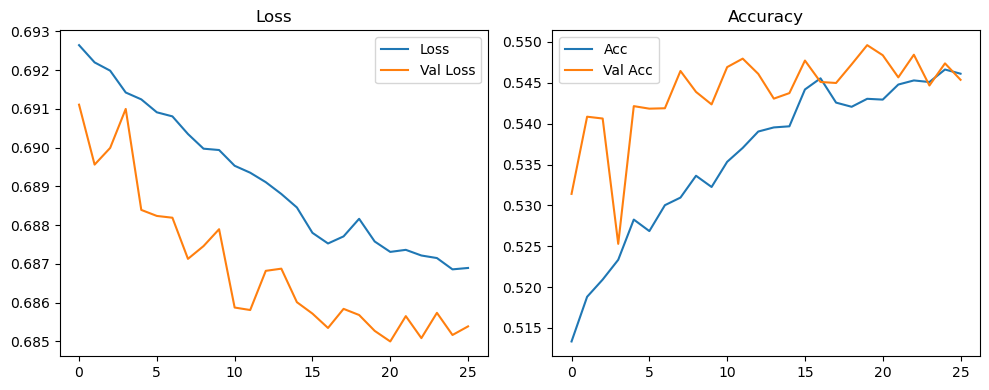

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Loss: 0.6850, Accuracy: 0.5484
SSIM: 0.1210, PSNR: 6.07 dB
Visualizing predictions...


NameError: name 'visualize_predictions' is not defined

In [5]:
# Plot history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate
def evaluate_model(model, gen):
    (e, o), y_true = gen[0]
    y_pred = model.predict([e, o])
    loss, acc = model.evaluate(gen, verbose=0)
    print(f"Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    try:
        y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float64)
        y_pred_tf = tf.convert_to_tensor(y_pred, dtype=tf.float64)
        ssim = tf.image.ssim(y_true_tf, y_pred_tf, max_val=1.0).numpy().mean()
        psnr = tf.image.psnr(y_true_tf, y_pred_tf, max_val=1.0).numpy().mean()
        print(f"SSIM: {ssim:.4f}, PSNR: {psnr:.2f} dB")
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")

evaluate_model(model, val_gen)


Found 1161 valid input-output pairs.
Inspecting training data samples...
Even input shape: (4, 32, 32, 1)
Odd input shape: (4, 32, 32, 1)
Output shape: (4, 50, 50, 1)


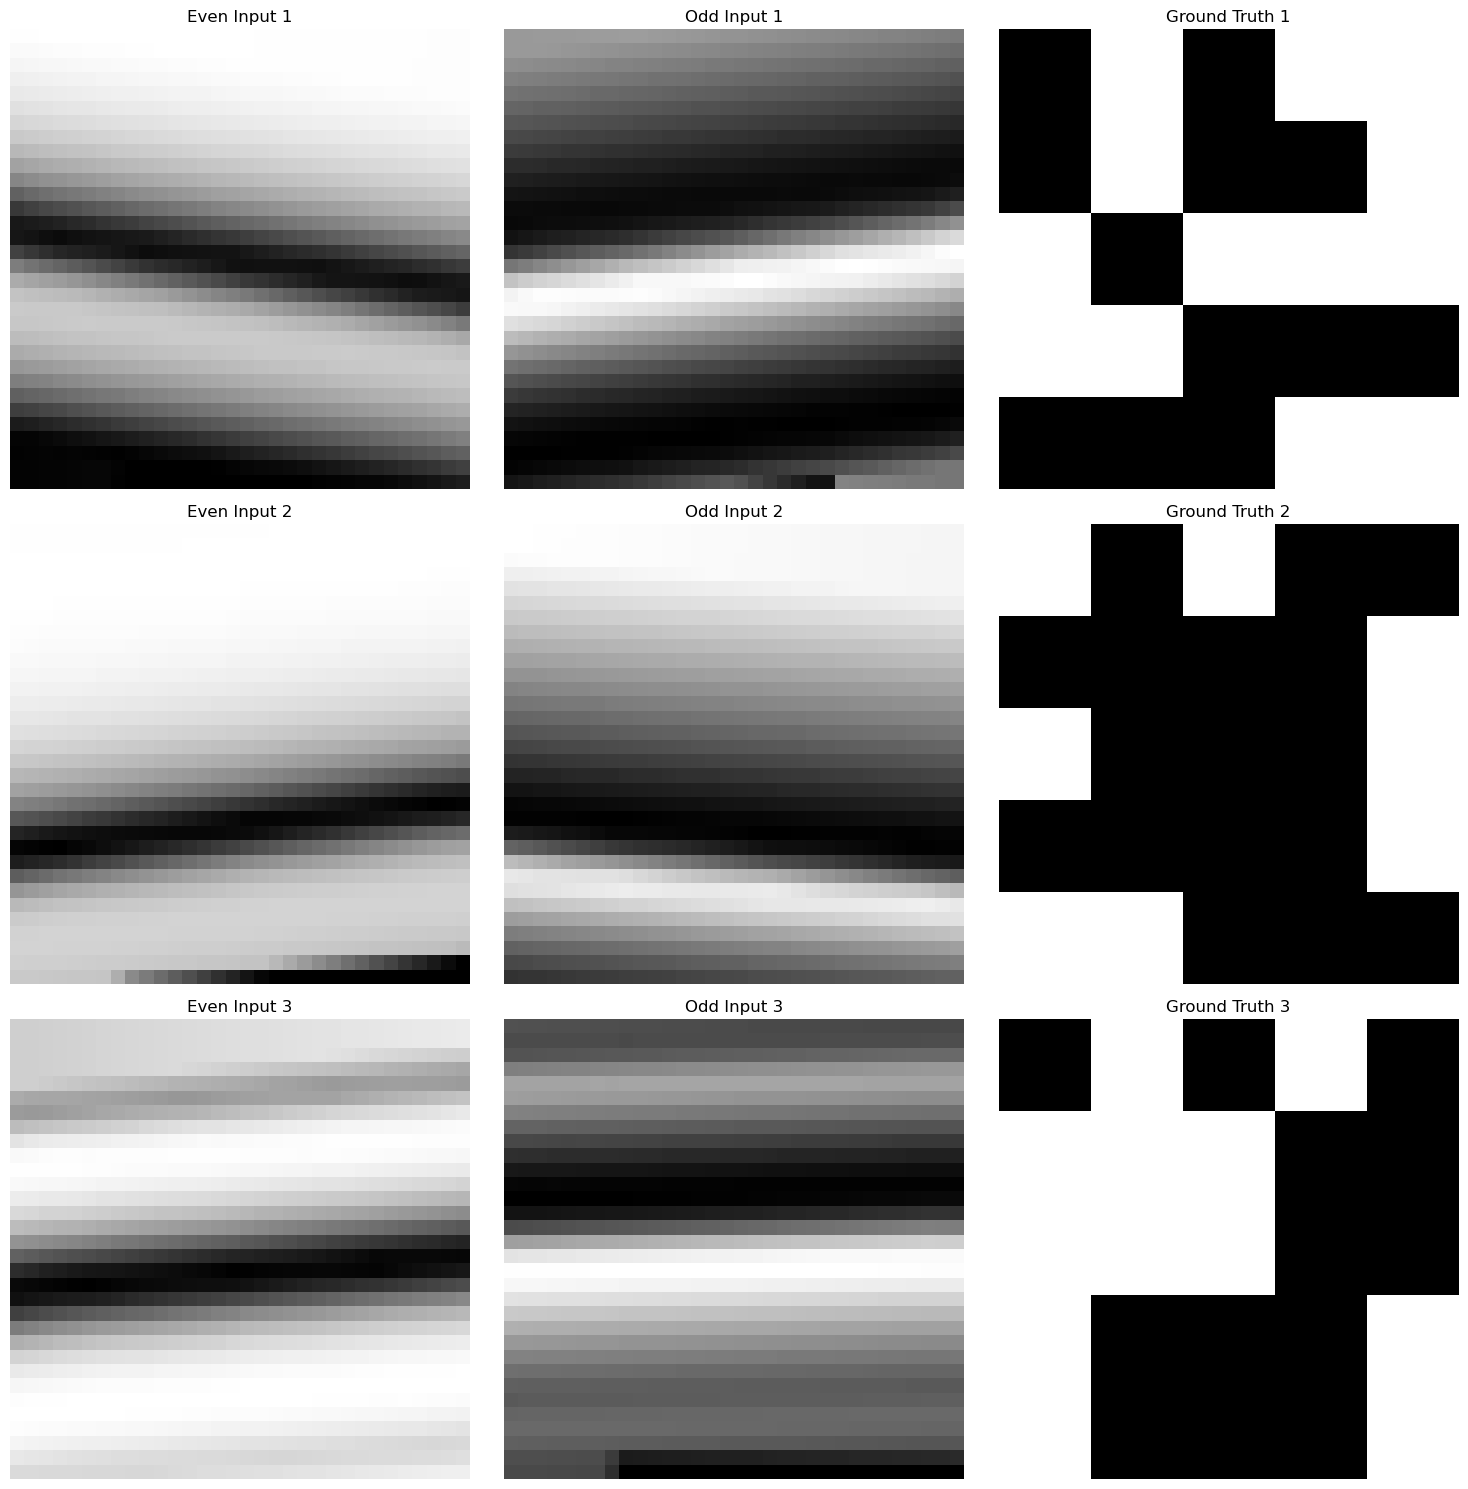

Testing minimal Conv2D model...
Minimal model test passed.
Testing model with dummy data...
Dummy data test passed.
Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5115 - loss: 0.6930 - val_accuracy: 0.5051 - val_loss: 0.6930 - learning_rate: 1.0000e-05
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5187 - loss: 0.6924 - val_accuracy: 0.5093 - val_loss: 0.6928 - learning_rate: 1.0000e-05
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5240 - loss: 0.6919 - val_accuracy: 0.5183 - val_loss: 0.6922 - learning_rate: 1.0000e-05
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5240 - loss: 0.6919 - val_accuracy: 0.5263 - val_loss: 0.6917 - learning_rate: 1.0000e-05
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5310 - loss: 0.6912 - val_accuracy: 0.5251 - val_loss: 0.6917 - learning_rate: 1.0000e-05
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5311 - loss: 0.6910 - val_accura

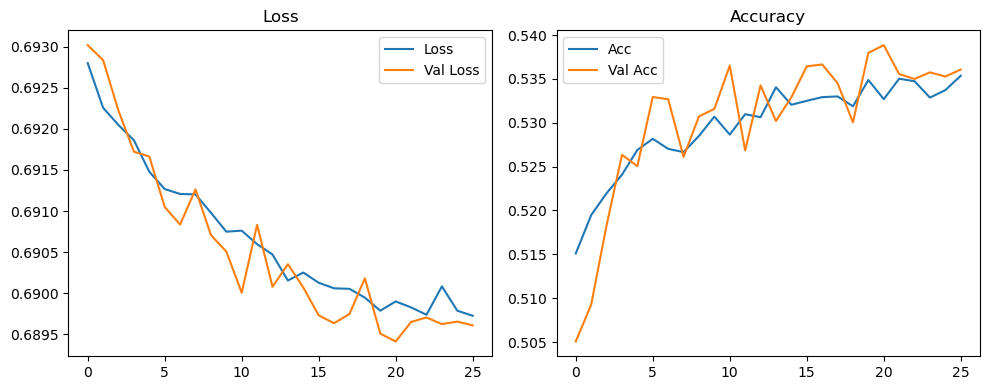

Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


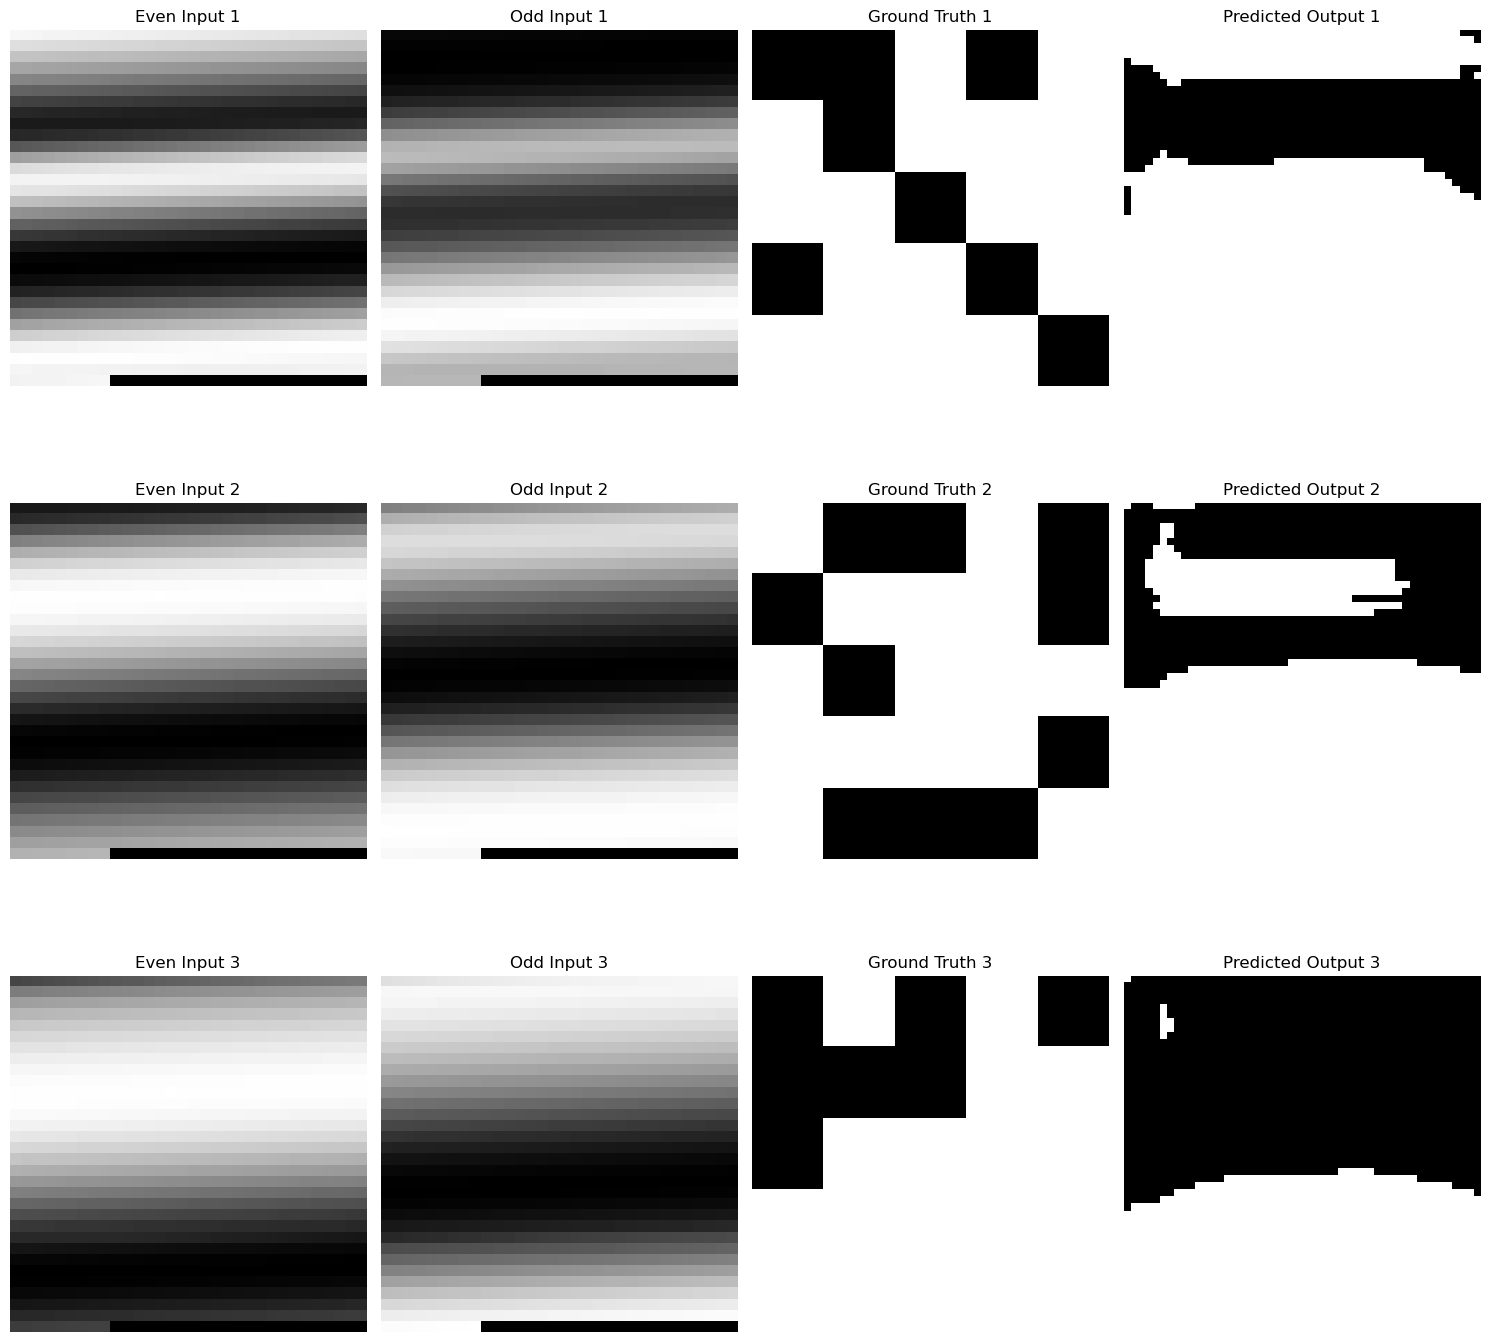

Unique values in predictions: [0. 1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Loss: 0.6894, Accuracy: 0.5388
SSIM: 0.2367, PSNR: 6.20 dB


In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force CPU
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)
output_shape = (50, 50, 1)
batch_size = 4
learning_rate = 1e-5
epochs = 50
block_size = 10

# Model
def build_dual_input_model(input_shape, output_shape):
    input_even = layers.Input(shape=input_shape, name="even_input")
    x1 = layers.Conv2D(32, 3, padding="same", activation="relu")(input_even)
    x1 = layers.MaxPooling2D()(x1)  # -> (16, 16, 32)
    x1 = layers.Conv2D(64, 3, padding="same", activation="relu")(x1)  # -> (16, 16, 64)

    input_odd = layers.Input(shape=input_shape, name="odd_input")
    x2 = layers.Conv2D(32, 3, padding="same", activation="relu")(input_odd)
    x2 = layers.MaxPooling2D()(x2)  # -> (16, 16, 32)
    x2 = layers.Conv2D(64, 3, padding="same", activation="relu")(x2)  # -> (16, 16, 64)

    x = layers.Concatenate()([x1, x2])  # -> (16, 16, 128)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)  # Reduce to 64 channels
    x = layers.UpSampling2D()(x)  # -> (32, 32, 64)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)  # -> (32, 32, 32)
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)  # -> (32, 32, 16)
    x = layers.Conv2D(1, 3, padding="same")(x)  # -> (32, 32, 1)
    x = layers.Resizing(output_shape[0], output_shape[1])(x)
    output = layers.Activation("sigmoid")(x)

    return models.Model(inputs=[input_even, input_odd], outputs=output)

# Data Generator
class ImagePairGenerator(Sequence):
    def __init__(self, even_dir, odd_dir, out_dir, batch_size, input_shape, output_shape, pairs, augment=False):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.out_dir = out_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.pairs = pairs
        self.augment = augment
        self.augmentation = KerasImageDataGenerator(
            rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
            zoom_range=0.1, horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        even_batch = np.zeros((len(batch), *self.input_shape))
        odd_batch = np.zeros((len(batch), *self.input_shape))
        out_batch = np.zeros((len(batch), *self.output_shape))

        for i, (e_path, o_path, m_path) in enumerate(batch):
            try:
                even = np.expand_dims(np.array(Image.open(e_path).convert('L').resize(self.input_shape[:2])) / 255.0, -1)
                odd = np.expand_dims(np.array(Image.open(o_path).convert('L').resize(self.input_shape[:2])) / 255.0, -1)
                matrix_img = np.array(Image.open(m_path).convert('L').resize(self.output_shape[:2]))
                matrix_bin = (matrix_img > 128).astype(np.float32)
                matrix_bin = matrix_bin.reshape(5, block_size, 5, block_size).mean(axis=(1, 3))
                matrix_bin = np.repeat(np.repeat((matrix_bin > 0.5).astype(np.float32), block_size, axis=0), block_size, axis=1)
                matrix_bin = np.expand_dims(matrix_bin, -1)

                if self.augment:
                    even = self.augmentation.random_transform(even)
                    odd = self.augmentation.random_transform(odd)

                even_batch[i] = even
                odd_batch[i] = odd
                out_batch[i] = matrix_bin
            except Exception as e:
                print(f"Error processing pair {e_path}, {o_path}, {m_path}: {str(e)}")
                continue

        return (even_batch, odd_batch), out_batch

# Prepare dataset
def get_valid_pairs():
    pairs = []
    missing_ids = []
    for f in os.listdir(output_dir):
        if not f.endswith('.png'):
            continue
        base = f[:-4]
        even_path = os.path.join(input_even_dir, f"{base}_even.png")
        odd_path = os.path.join(input_odd_dir, f"{base}_odd.png")
        out_path = os.path.join(output_dir, f)
        if os.path.exists(even_path) and os.path.exists(odd_path):
            pairs.append((even_path, odd_path, out_path))
        else:
            missing_ids.append(base)
    if missing_ids:
        print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
    return pairs

# Inspect data
def inspect_data(generator, num_samples=3):
    (even_inputs, odd_inputs), outputs = generator[0]
    print("Even input shape:", even_inputs.shape)
    print("Odd input shape:", odd_inputs.shape)
    print("Output shape:", outputs.shape)
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions
def visualize_predictions(model, generator, num_samples=3):
    (even_inputs, odd_inputs), true_outputs = generator[0]
    predictions = model.predict([even_inputs, odd_inputs])
    predictions = (predictions > 0.5).astype(np.float32)  # Threshold for binary output

    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(true_outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(predictions[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Predicted Output {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("Unique values in predictions:", np.unique(predictions))

pairs = get_valid_pairs()
print(f"Found {len(pairs)} valid input-output pairs.")
np.random.shuffle(pairs)
split = int(0.8 * len(pairs))
train_pairs = pairs[:split]
val_pairs = pairs[split:]

train_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, train_pairs, augment=True)
val_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, val_pairs)

# Inspect data before training
print("Inspecting training data samples...")
inspect_data(train_gen)

# Test minimal model
print("Testing minimal Conv2D model...")
input_test = layers.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_test)
model_test = models.Model(inputs=input_test, outputs=x)
model_test.compile(optimizer='adam', loss='mse')
try:
    model_test.predict(np.zeros((1, 32, 32, 1)), verbose=0)
    print("Minimal model test passed.")
except Exception as e:
    print(f"Minimal model test failed: {str(e)}")

# Test model with dummy data
print("Testing model with dummy data...")
model = build_dual_input_model(input_shape, output_shape)
model.compile(optimizer='adam', loss='binary_crossentropy')
try:
    dummy_even = np.random.rand(4, 32, 32, 1).astype(np.float32)
    dummy_odd = np.random.rand(4, 32, 32, 1).astype(np.float32)
    dummy_out = np.random.randint(0, 2, (4, 50, 50, 1)).astype(np.float32)
    model.train_on_batch([dummy_even, dummy_odd], dummy_out)
    print("Dummy data test passed.")
except Exception as e:
    print(f"Dummy data test failed: {str(e)}")

model = build_dual_input_model(input_shape, output_shape)
model.compile(optimizer=optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Train using generator directly
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)
model.save("image_translation_model_final.keras")

# Plot history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate
def evaluate_model(model, gen):
    (e, o), y_true = gen[0]
    y_pred = model.predict([e, o])
    loss, acc = model.evaluate(gen, verbose=0)
    print(f"Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    try:
        y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float64)
        y_pred_tf = tf.convert_to_tensor(y_pred, dtype=tf.float64)
        ssim = tf.image.ssim(y_true_tf, y_pred_tf, max_val=1.0).numpy().mean()
        psnr = tf.image.psnr(y_true_tf, y_pred_tf, max_val=1.0).numpy().mean()
        print(f"SSIM: {ssim:.4f}, PSNR: {psnr:.2f} dB")
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")

# Visualize predictions after training
print("Visualizing predictions...")
visualize_predictions(model, val_gen)

evaluate_model(model, val_gen)

Found 1161 valid input-output pairs.
Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.5002 - loss: 1.0065 - val_accuracy: 0.4955 - val_loss: 0.9663 - learning_rate: 0.0010
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.4971 - loss: 0.9610 - val_accuracy: 0.4924 - val_loss: 0.9577 - learning_rate: 0.0010
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.4939 - loss: 0.9570 - val_accuracy: 0.4932 - val_loss: 0.9555 - learning_rate: 0.0010
Epoch 4/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.4951 - loss: 0.9545 - val_accuracy: 0.4955 - val_loss: 0.9629 - learning_rate: 0.0010
Epoch 5/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.4951 - loss: 0.9548 - val_accuracy: 0.4922 - val_loss: 0.9529 - learning_rate: 0.0010
Epoch 6/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.5037 - loss: 0.9517 - val_accuracy: 0.4924 - val_loss: 0.9513 - learning_rate: 0.0010
Epoch 7/100
232/232 ━━━━━━━━━━━━━

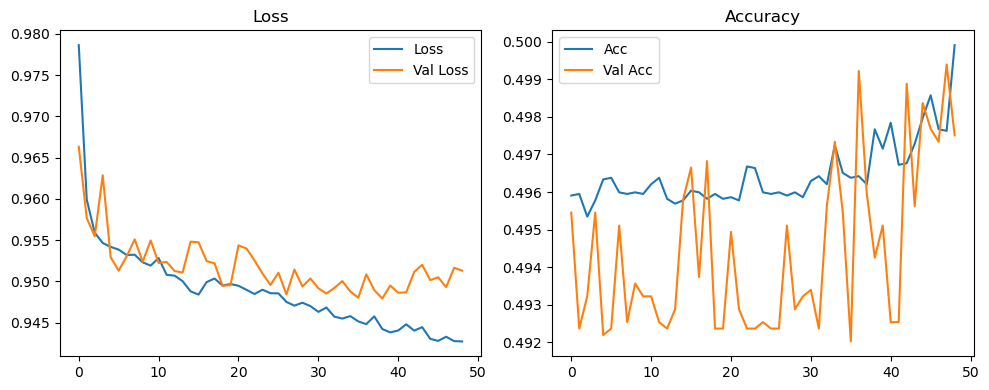

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Loss: 0.9479, Accuracy: 0.4942
SSIM: 0.1432, PSNR: 5.65 dB
Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


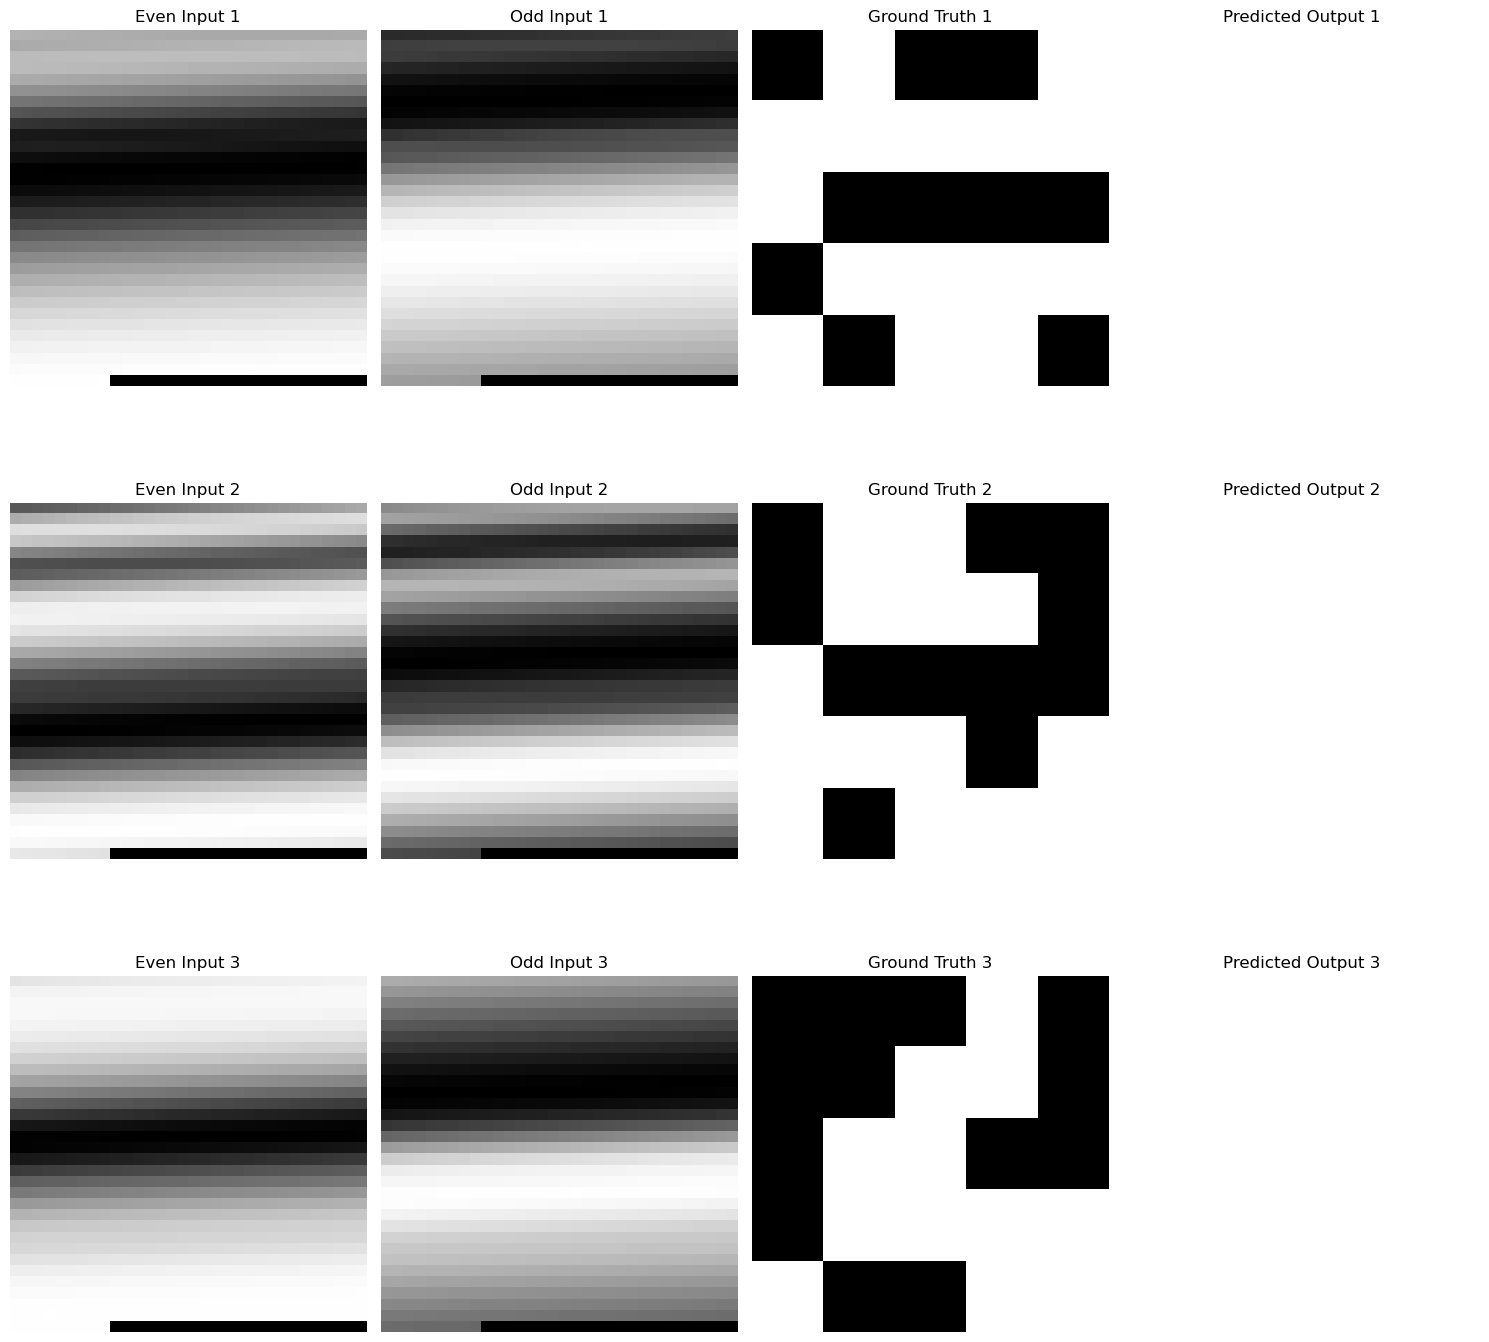

In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force CPU
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)
output_shape = (50, 50, 1)
batch_size = 4
learning_rate = 1e-3
epochs = 100
block_size = 10

# Custom Layer - Modified to maintain differentiability
class BlockUniformityLayer(layers.Layer):
    def __init__(self, block_size=10, **kwargs):
        super().__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        # Reshape and average blocks
        x = tf.reshape(inputs, [-1, 5, self.block_size, 5, self.block_size, 1])
        x = tf.reduce_mean(x, axis=[2, 4])  # -> (batch_size, 5, 5, 1)
        # Repeat values to expand back to original size
        x = tf.repeat(x, self.block_size, axis=1)  # -> (batch_size, 50, 5, 1)
        x = tf.repeat(x, self.block_size, axis=2)  # -> (batch_size, 50, 50, 1)
        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 50, 50, 1)

# Fixed Custom Loss - now returns scalar per batch
def weighted_binary_crossentropy(y_true, y_pred):
    # Calculate binary cross entropy per pixel
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)  # shape: (batch_size, 50, 50)
    
    # Calculate block weights (batch_size, 5, 5, 1)
    block_weight = tf.reduce_mean(tf.reshape(y_true, [-1, 5, block_size, 5, block_size, 1]), axis=[2, 4])
    block_weight = tf.where(block_weight > 0.5, 2.0, 1.0)
    
    # Expand weights to match bce shape and remove extra dimensions
    block_weight = tf.repeat(tf.repeat(block_weight, block_size, axis=1), block_size, axis=2)
    block_weight = tf.squeeze(block_weight)  # shape: (batch_size, 50, 50)
    
    # Weight the bce and return mean over all pixels
    weighted_bce = bce * block_weight
    return tf.reduce_mean(weighted_bce)  # Scalar per batch

# Model with modified architecture
def build_dual_input_model(input_shape, output_shape):
    # Even input branch
    input_even = layers.Input(shape=input_shape, name="even_input")
    e1 = layers.Conv2D(64, 3, padding="same", activation="relu")(input_even)
    e1 = layers.BatchNormalization()(e1)
    e2 = layers.MaxPooling2D()(e1)  # -> (16, 16, 64)
    e3 = layers.Conv2D(128, 3, padding="same", activation="relu")(e2)
    e3 = layers.BatchNormalization()(e3)
    e4 = layers.Conv2D(256, 3, padding="same", activation="relu")(e3)
    e4 = layers.BatchNormalization()(e4)  # -> (16, 16, 256)

    # Odd input branch
    input_odd = layers.Input(shape=input_shape, name="odd_input")
    o1 = layers.Conv2D(64, 3, padding="same", activation="relu")(input_odd)
    o1 = layers.BatchNormalization()(o1)
    o2 = layers.MaxPooling2D()(o1)  # -> (16, 16, 64)
    o3 = layers.Conv2D(128, 3, padding="same", activation="relu")(o2)
    o3 = layers.BatchNormalization()(o3)
    o4 = layers.Conv2D(256, 3, padding="same", activation="relu")(o3)
    o4 = layers.BatchNormalization()(o4)  # -> (16, 16, 256)

    # Combined processing
    x = layers.Concatenate()([e4, o4])  # -> (16, 16, 512)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.UpSampling2D()(x)  # -> (32, 32, 256)
    
    # Skip connection
    x = layers.Concatenate()([x, layers.Concatenate()([e1, o1])])
    
    # Final processing
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)  # Sigmoid here
    x = layers.Resizing(output_shape[0], output_shape[1])(x)
    output = BlockUniformityLayer(block_size=10)(x)  # No activation needed

    return models.Model(inputs=[input_even, input_odd], outputs=output)

# Data Generator (unchanged)
class ImagePairGenerator(Sequence):
    def __init__(self, even_dir, odd_dir, out_dir, batch_size, input_shape, output_shape, pairs, augment=False):
        self.even_dir = even_dir
        self.odd_dir = odd_dir
        self.out_dir = out_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.pairs = pairs
        self.augment = augment
        self.augmentation = KerasImageDataGenerator(
            rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
            zoom_range=0.2, horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        even_batch = np.zeros((len(batch), *self.input_shape))
        odd_batch = np.zeros((len(batch), *self.input_shape))
        out_batch = np.zeros((len(batch), *self.output_shape))

        for i, (e_path, o_path, m_path) in enumerate(batch):
            try:
                even = np.expand_dims(np.array(Image.open(e_path).convert('L').resize(self.input_shape[:2])) / 255.0, -1)
                odd = np.expand_dims(np.array(Image.open(o_path).convert('L').resize(self.input_shape[:2])) / 255.0, -1)
                matrix_img = np.array(Image.open(m_path).convert('L').resize(self.output_shape[:2]))
                matrix_bin = (matrix_img > 128).astype(np.float32)
                matrix_bin = matrix_bin.reshape(5, block_size, 5, block_size).mean(axis=(1, 3))
                matrix_bin = np.repeat(np.repeat((matrix_bin > 0.5).astype(np.float32), block_size, axis=0), block_size, axis=1)
                matrix_bin = np.expand_dims(matrix_bin, -1)

                if self.augment:
                    even = self.augmentation.random_transform(even)
                    odd = self.augmentation.random_transform(odd)

                even_batch[i] = even
                odd_batch[i] = odd
                out_batch[i] = matrix_bin
            except Exception as e:
                print(f"Error processing pair {e_path}, {o_path}, {m_path}: {str(e)}")
                continue

        return (even_batch, odd_batch), out_batch

# Prepare dataset (unchanged)
def get_valid_pairs():
    pairs = []
    missing_ids = []
    for f in os.listdir(output_dir):
        if not f.endswith('.png'):
            continue
        base = f[:-4]
        even_path = os.path.join(input_even_dir, f"{base}_even.png")
        odd_path = os.path.join(input_odd_dir, f"{base}_odd.png")
        out_path = os.path.join(output_dir, f)
        if os.path.exists(even_path) and os.path.exists(odd_path):
            pairs.append((even_path, odd_path, out_path))
        else:
            missing_ids.append(base)
    if missing_ids:
        print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
    return pairs

# Training setup
pairs = get_valid_pairs()
print(f"Found {len(pairs)} valid input-output pairs.")
np.random.shuffle(pairs)
split = int(0.8 * len(pairs))
train_pairs = pairs[:split]
val_pairs = pairs[split:]

train_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, train_pairs, augment=True)
val_gen = ImagePairGenerator(input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, val_pairs)

# Build and compile model
model = build_dual_input_model(input_shape, output_shape)
model.compile(
    optimizer=optimizers.Adam(learning_rate, clipnorm=1.0),
    loss=weighted_binary_crossentropy,
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)

# Save final model
model.save("image_translation_model_final.keras")

# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation function
def evaluate_model(model, gen):
    (e, o), y_true = gen[0]
    y_pred = model.predict([e, o])
    loss, acc = model.evaluate(gen, verbose=0)
    print(f"Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    try:
        y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float64)
        y_pred_tf = tf.convert_to_tensor(y_pred, dtype=tf.float64)
        ssim = tf.image.ssim(y_true_tf, y_pred_tf, max_val=1.0).numpy().mean()
        psnr = tf.image.psnr(y_true_tf, y_pred_tf, max_val=1.0).numpy().mean()
        print(f"SSIM: {ssim:.4f}, PSNR: {psnr:.2f} dB")
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")

# Visualize predictions
def visualize_predictions(model, generator, num_samples=3):
    (even_inputs, odd_inputs), true_outputs = generator[0]
    predictions = model.predict([even_inputs, odd_inputs])
    predictions = (predictions > 0.5).astype(np.float32)

    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(true_outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(predictions[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Predicted Output {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run evaluation and visualization
print("Evaluating model...")
evaluate_model(model, val_gen)

print("Visualizing predictions...")
visualize_predictions(model, val_gen)